In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation_lockdown import MultiGroupSimulation

In [2]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    list_dfs = list()
    for sim_group in sim.sims:
        list_dfs.append(sim_group.sim_df)
    return list_dfs

def run_multiple_trajectories(sim, T, n):
    sim_results = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        sim_results.append(result)
    return sim_results

def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)
    
    group_size = list()
    tests_per_day = 0
    
    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]
    
    assert len(group_size) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    sim_results = run_multiple_trajectories(sim, T, n)
    return tests_per_day, sim_results

### August 28 - Sept 1 cases

In [3]:
def sample_pre_sim_cases():
    pre_sim_cases = list()
    pre_sim_cases.append(9) # August 28
    pre_sim_cases.append(4) # August 29
    pre_sim_cases.append(np.random.poisson(2)) # August 30
    pre_sim_cases.append(np.random.poisson(2)) # August 31
    pre_sim_cases.append(np.random.poisson(2)) # Sept 1
    return pre_sim_cases

### Sim Cases

In [4]:
base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/nominal/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [5]:
# Vet school: 300 students
gs_other_params['population_size'] = gs_other_params['population_size'] - 300

In [6]:
policy = [2/7,2/7,1/7,2/7,2/7,1/7,1/30,0]
interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [7]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day_nominal, sim_results_nominal = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 84, 50)

In [ ]:
# Finding list of new found cases per day

# Simulate number of FPs per day


In [8]:
print(sim_results_nominal[0][1])
# print(sim_results_nominal[0][0][['cumulative_mild','cumulative_severe','SyID_mild','new_real_cases','new_cases']])
print(np.cumsum(sim_results_nominal[0][1]['new_real_cases']), np.cumsum(sim_results_nominal[0][0]['new_cases']))
print(sim_results_nominal[0][1].missed_cases)

       S   QS  QI    R E_0 E_1 E_2 E_3 E_4 E_5  ... cumulative_mild  \
0   7622    0   0    0   0   0   0   0   0   0  ...               0   
1   7616    4   2    0   0   0   1   0   0   0  ...               1   
2   7605   12   3    1   0   1   0   1   1   0  ...               5   
3   7596   17   4    1   1   3   1   1   0   0  ...               5   
4   7592   19   4    3   4   1   2   0   0   0  ...               7   
..   ...  ...  ..  ...  ..  ..  ..  ..  ..  ..  ...             ...   
80  7270  152  49  140   1   0   0   0   0   0  ...             110   
81  7267  150  46  148   0   1   1   1   1   0  ...             114   
82  7258  153  47  151   4   2   2   0   0   0  ...             116   
83  7256  148  46  155   4   3   1   1   0   0  ...             118   
84  7245  152  48  160   6   1   3   0   0   0  ...             120   

   cumulative_severe cumulative_outside_infections new_real_cases new_cases  \
0                  0                             0              0   

In [9]:
sim_results_nominal[0][1].to_csv('Aug_29_sim_df.csv')

In [9]:
def get_total_new_cases(sim_dfs, include_array):
    assert len(sim_dfs) == len(include_array)
    if include_array[0] == True:
        cases = sim_dfs[0]['new_cases']
    else:
        cases = sim_dfs[0]['new_cases'] - sim_dfs[0]['new_cases']
    for i in range(1, len(sim_dfs)):
        if include_array[i] == True:
            cases += sim_dfs[i]['new_cases']
    return cases

In [10]:
cornell_case_counts = list()
student_case_counts = list()
for sim_dfs in sim_results_nominal:
    pre_sim_cases = sample_pre_sim_cases()
    student_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases(sim_dfs, [True, True, True, True, False, False, False, False]))]))
    cornell_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases(sim_dfs, [True, True, True, True, True, True, True, False]))]))

Text(0.5, 0, 'Day')

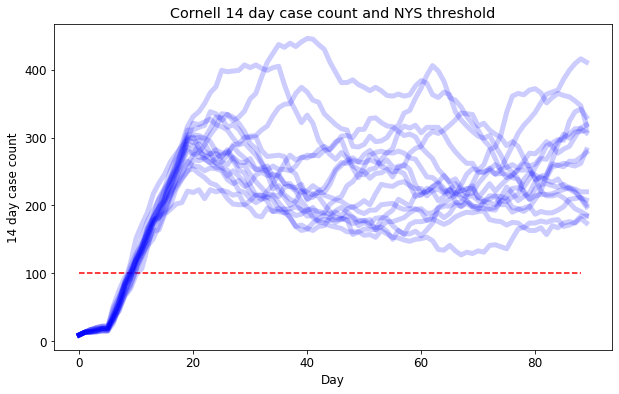

In [13]:
plt.figure(figsize=(10,6))
for new_case_trajectory in cornell_case_counts[:15]:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    plt.plot(window_case_trajectory, color='blue', alpha=0.2, linewidth=5)
plt.hlines(100, 0, 88, colors='red', linestyles='dashed')
plt.title('Cornell 14 day case count and NYS threshold')
plt.ylabel('14 day case count')
plt.xlabel('Day')

Text(0.5, 0, 'Day')

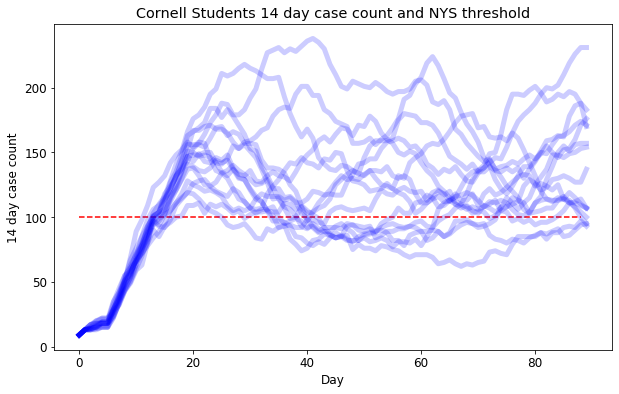

In [14]:
plt.figure(figsize=(10,6))
for new_case_trajectory in student_case_counts[:15]:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    plt.plot(window_case_trajectory, color='blue', alpha=0.2, linewidth=5)
plt.hlines(100, 0, 88, colors='red', linestyles='dashed')
plt.title('Cornell Students 14 day case count and NYS threshold')
plt.ylabel('14 day case count')
plt.xlabel('Day')

In [78]:
print(cornell_case_counts[0])
print(student_case_counts[0])

[9 4 1 2 0 0 239 150 254 288 173 245 300 196 193 150 132 187 138 133 152
 99 94 205 142 232 145 182 209 191 236 365 185 207 229 238 159 85 155 108
 127 152 136 155 281 202 340 215 72 233 88 118 188 145 154 159 204 152 165
 214 111 159 152 130 192 109 159 54 216 190 106 75 108 83 154 271 160 181
 151 234 173 281 179 78 127 128 122 136 185 137]
[9 4 1 2 0 0 226 142 241 274 165 234 286 187 185 143 125 178 130 125 144
 94 89 194 134 220 138 173 198 181 223 347 176 196 217 225 151 82 148 103
 120 144 129 147 266 192 322 204 69 221 84 112 178 137 147 152 193 144 156
 203 104 151 143 124 181 103 150 51 205 181 100 71 102 78 146 257 151 171
 144 221 164 266 170 74 121 121 117 130 176 131]


In [45]:
sim_results_nominal[0][0]['new_cases'] + sim_results_nominal[0][1]['new_cases'] + sim_results_nominal[0][2]['new_cases'] + sim_results_nominal[0][3]['new_cases'], sim_results_nominal[0][0]['new_cases'] + sim_results_nominal[0][1]['new_cases'] + sim_results_nominal[0][2]['new_cases'] + sim_results_nominal[0][3]['new_cases'] + sim_results_nominal[0][4]['new_cases'] + sim_results_nominal[0][5]['new_cases'] + sim_results_nominal[0][6]['new_cases']

(0      0
 1     39
 2     29
 3     49
 4     53
       ..
 80    24
 81    25
 82    29
 83    37
 84    29
 Name: new_cases, Length: 85, dtype: object,
 0      0
 1     42
 2     32
 3     53
 4     56
       ..
 80    27
 81    25
 82    30
 83    39
 84    29
 Name: new_cases, Length: 85, dtype: object)

In [75]:
print(get_total_new_cases(sim_results_nominal[1], [False, True, False, False, False, False, False, False]))
print(get_total_new_cases(sim_results_nominal[1], [True, True, True, True, False, False, False, False]))
print(get_total_new_cases(sim_results_nominal[1], [True, True, True, True, True, True, True, False]))

0     0
1     5
2     7
3     5
4     9
     ..
80    3
81    3
82    2
83    5
84    4
Name: new_cases, Length: 85, dtype: object
0      0
1     45
2     50
3     64
4     80
      ..
80    36
81    45
82    27
83    56
84    40
Name: new_cases, Length: 85, dtype: object
0      0
1     54
2     58
3     78
4     94
      ..
80    43
81    56
82    32
83    66
84    47
Name: new_cases, Length: 85, dtype: object
